In [1]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax_csv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [2]:
import kb_python.utils as kb_utils
import numpy as np
import gget
from scipy import stats
import anndata
import pandas as pd
import json
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

# Load data

In [3]:
palmdb_adata = anndata.read(f"{fastq_folder}/host_flag/virus_cdna_dna_masked_meta.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'
    var: 'v_type'

In [179]:
palmdb_adata.X.max()

1.0

#### Load ID to taxonomy mapping

In [7]:
phylogeny_data = pd.read_csv(u_tax_csv)

# Drop columns not needed here
phylogeny_data = phylogeny_data.drop("ID", axis=1).drop("strandedness", axis=1).drop_duplicates()
phylogeny_data

,rep_ID,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
409,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
475,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
590,u102,Kitrinoviricota,Alsuviricetes,Hepelivirales,Hepeviridae,Orthohepevirus,Orthohepevirus A
909,u113,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Morbillivirus,Measles morbillivirus
...,...,...,...,...,...,...,...
296556,u296608,.,.,.,.,.,.
296557,u296609,.,.,.,.,.,.
296558,u296613,.,.,.,.,.,.
296559,u296616,.,.,.,.,.,.


___

In [51]:
virs = [
    # Macaque only
    'u39566', 'u102540', 'u11150', 'u10',
    # Shared
    'u288819',
 'u290519',
 'u10240',
 'u183255',
 'u1001',
 'u100291',
 'u103829',
 'u110641',
 'u181379',
 'u202260',
 'u135858',
 'u101227',
 'u100188',
 'u27694',
 'u34159',
 'u100245',
 'u10015',
 'u100733',
 'u100173',
 'u100196',
 'u100599',
 'u100644',
 'u100296',
 'u100017',
 'u100002',
 'u100012',
 'u100024',
 'u100048',
 'u100302',
 'u100074',
 'u100289',
 'u100026',
 'u100111',
 'u100139',
 'u100154',
 'u100251',
 'u100177',
 'u100215',
 'u100049',
 'u100000',
 'u100001',
 'u100007',
 'u100004',
 'u100011',
 'u100093',
 'u100116',
 'u100019',
 'u100076',
 'u100028',
 'u100153',
 'u100031',
 'u100145',
 'u102324',
 'u134800'
]

In [144]:
# Minimum fraction of positive cells to count virus as present in sample
threshold = 0.0005

In [145]:
animals = palmdb_adata.obs["donor_animal"].unique()
animal_fracs = []
for vir in virs:
    pos_fracs = []
    for animal_id in animals:
        # Get number of positive cells per animal
        num_pos_cells = palmdb_adata[palmdb_adata.obs["donor_animal"] == animal_id, palmdb_adata.var.index.values == vir].X.sum()
        total_num_cells = len(palmdb_adata.obs[palmdb_adata.obs["donor_animal"] == animal_id])
        pos_fracs.append(num_pos_cells/total_num_cells)
        
    # Get number of animals with > threshold positive cells
    pos_animals = sum(i >= threshold for i in pos_fracs)
    
    animal_fracs.append(np.array(pos_animals) / len(animals))

In [146]:
tps = palmdb_adata.obs["dpi_clean_merged"].unique()
tp_fracs = []
for vir in virs:
    pos_fracs = []
    for tp in tps:
        # Get number of positive cells per time point
        num_pos_cells = palmdb_adata[palmdb_adata.obs["dpi_clean_merged"] == tp, palmdb_adata.var.index.values == vir].X.sum()
        total_num_cells = len(palmdb_adata.obs[palmdb_adata.obs["dpi_clean_merged"] == tp])
        pos_fracs.append(num_pos_cells/total_num_cells)
        
    # Get number of animals with > threshold positive cells
    pos_tps = sum(i >= threshold for i in pos_fracs)
    
    tp_fracs.append(np.array(pos_tps) / len(tps))

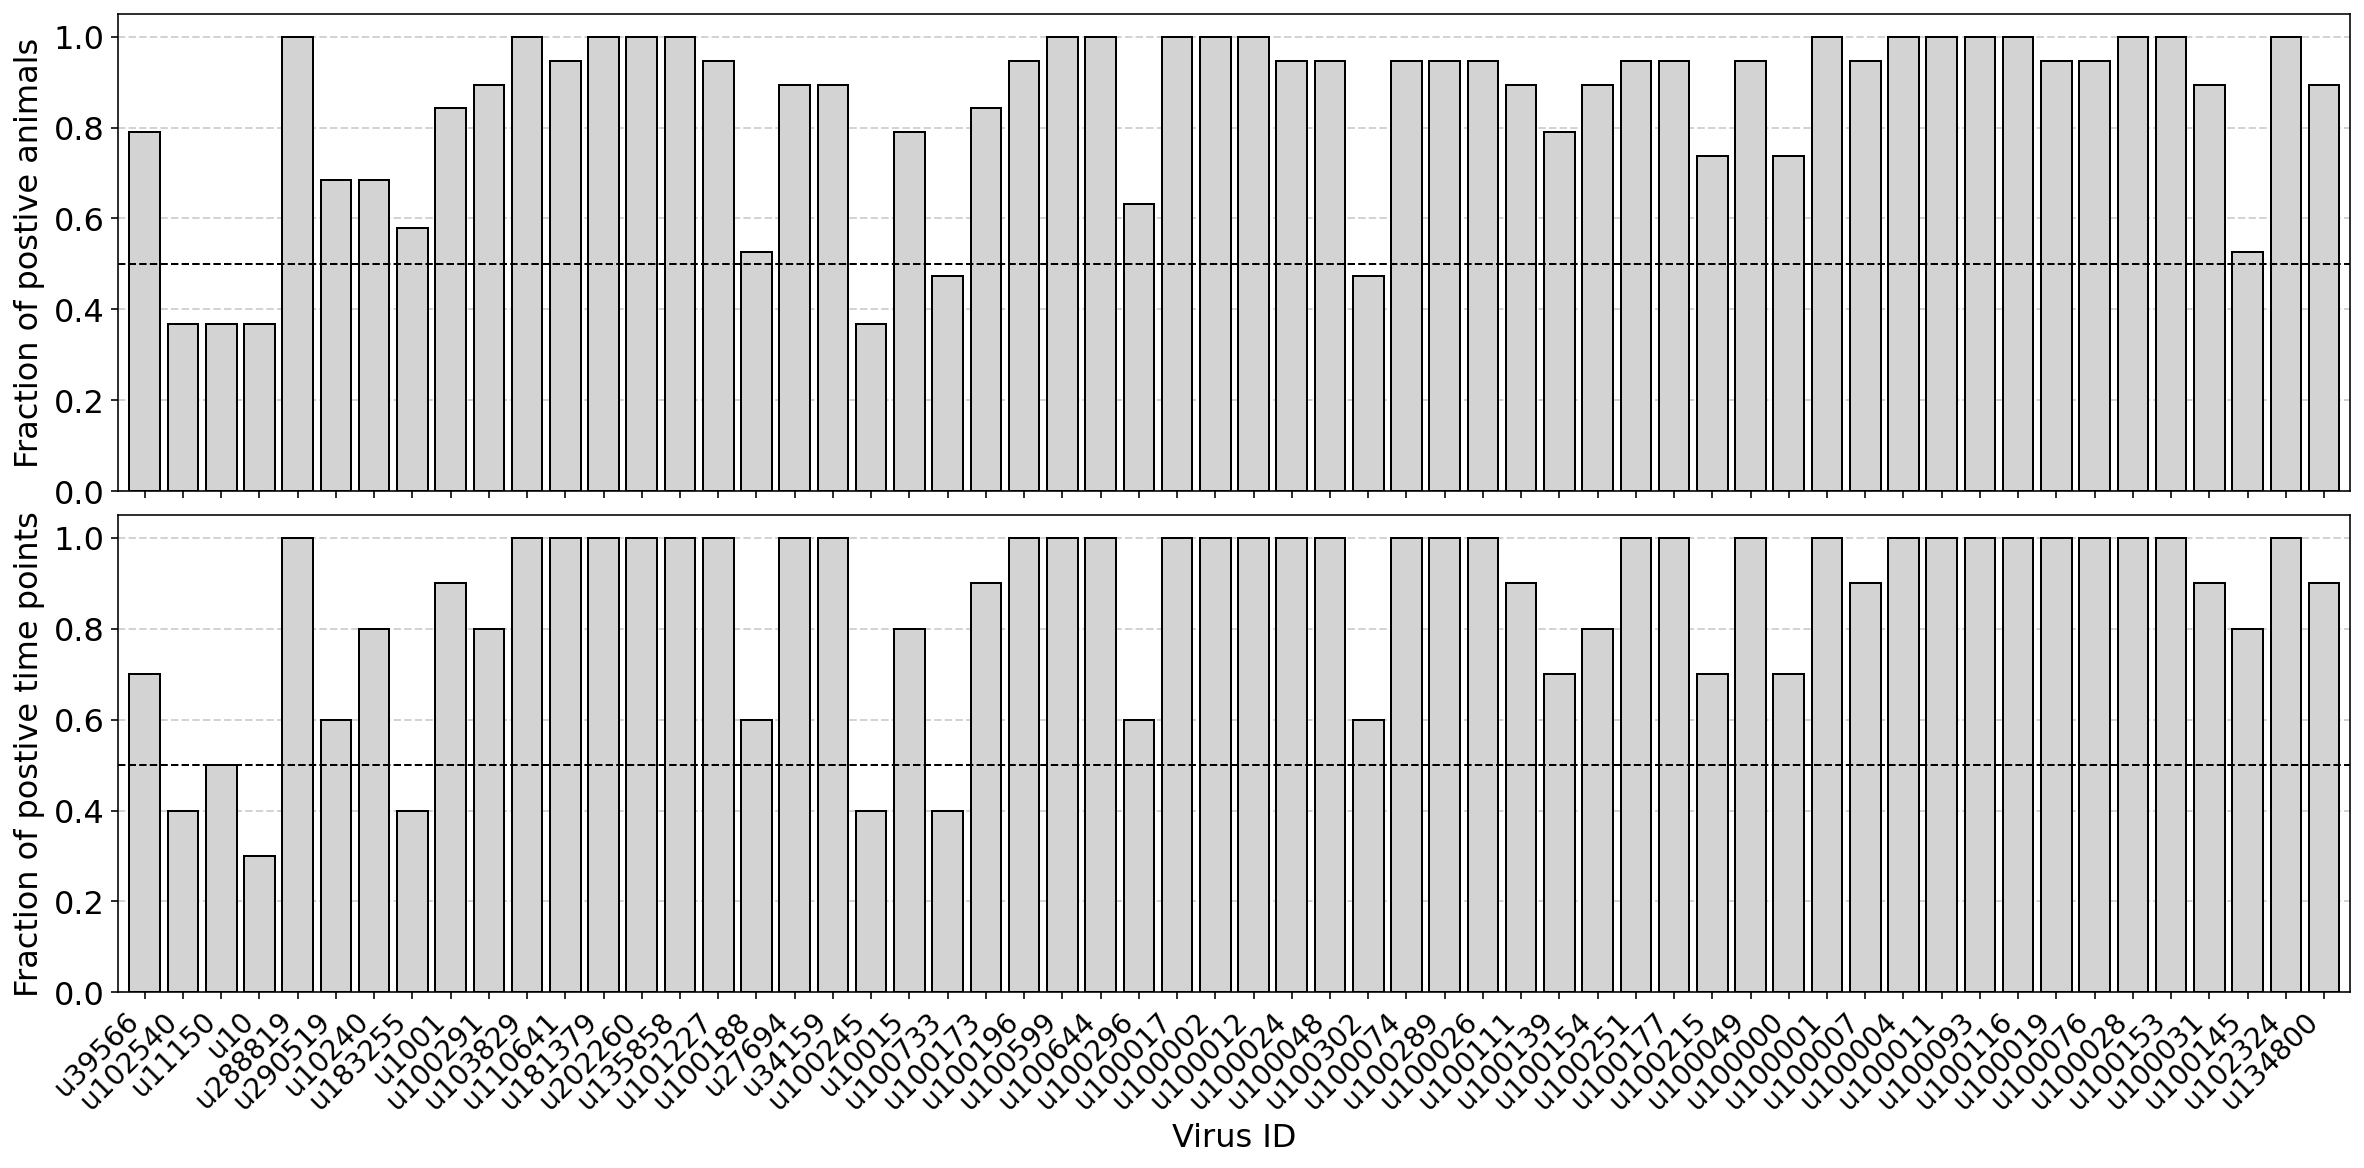

In [174]:
fig, axs = plt.subplots(figsize=(20,9), nrows=2, sharex=True)
fontsize = 16

ax = axs[0]
ax.bar(virs, animal_fracs, color="lightgrey", ec="black")
ax.set_ylabel("Fraction of postive animals", fontsize=fontsize)
ax.set_xticklabels("")
ax.tick_params(axis="both", labelsize=fontsize)
ax.axhline(0.5, c="black", ls="--", lw=1)
ax.margins(x=0.005)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

ax = axs[1]
ax.bar(virs, tp_fracs, color="lightgrey", ec="black")
ax.set_ylabel("Fraction of postive time points", fontsize=fontsize)
ax.set_xlabel("Virus ID", fontsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_xticklabels(virs, rotation=45, ha="right", fontsize=fontsize-2)
ax.axhline(0.5, c="black", ls="--", lw=1)
ax.margins(x=0.005)

plt.subplots_adjust(hspace=0.05)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

plt.savefig("figures/4.2.1_virus_frequencies.png", dpi=300, bbox_inches="tight")

fig.show()

Plot difference in positive cell counts for the same animal between time points:

In [96]:
def rand_jitter(arr, jitter_size=0.02):
    """
    Add random jitter to array to avoid overplotting.
    """
    return np.random.uniform(low=-jitter_size, high=jitter_size, size=(len(arr),))

In [157]:
# Sort animal IDs by difference in time
animal_ids_sorted = [    
    # 20 hours apart
    'NHP1',
    'NHP2',
    # 3 days apart
    'NHP13',
    'NHP14',
    'NHP15',
    # 5 days apart
    'NHP16',
    'NHP17',
    'NHP18',
    # 10 days apart
    'NHP08',
    'NHP11',
    # 11 days apart
    'NHP10',
    # 12 days apart
    'NHP09',
    # 36 days apart
    'NHP23',
]

time_difs = [
    "20h",
    "20h",
    "3d",
    "3d",
    "3d",
    "5d",
    "5d",
    "5d",
    "10d",
    "10d",
    "11d",
    "12d",
    "36d",
]

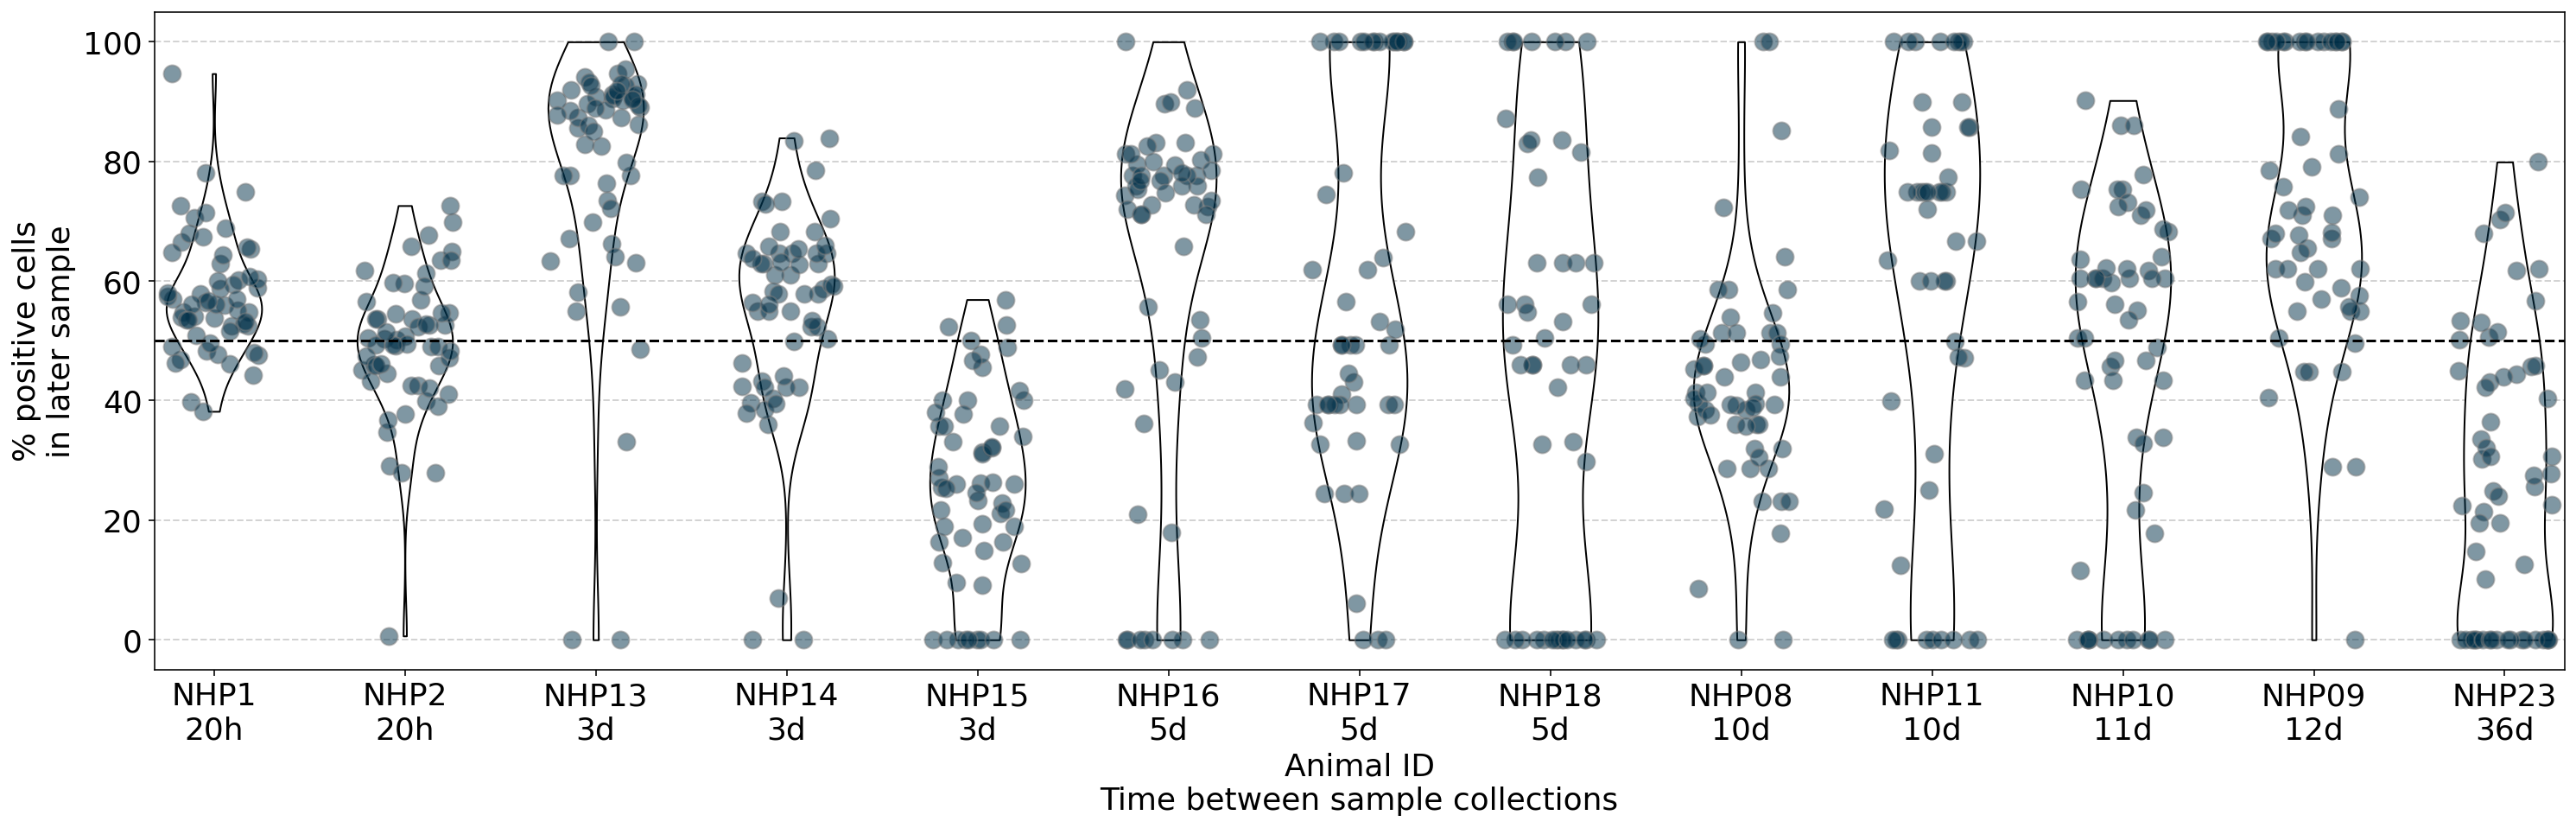

In [173]:
fig, ax = plt.subplots(figsize=(25,7))
fontsize = 18

s=100
width=0.5
color = "#003049" # Change to #b266b3 for black bkg
background = "white"
label_color = "black"
grid_color = "lightgrey"

x = 0
for animal_id in animal_ids_sorted:
    fcs = []
    first_frac = []
    second_frac = []
    for vir in virs:
        # Collect positive cells per time point
        pos_cells = []
        for tp in palmdb_adata.obs[palmdb_adata.obs["donor_animal"] == animal_id]["dpi_clean_merged"].unique():
            # Get positive cell count
            posc = palmdb_adata[(palmdb_adata.obs["dpi_clean_merged"] == tp) & (palmdb_adata.obs["donor_animal"] == animal_id), palmdb_adata.var.index.values == vir].X.sum()
            
            # Normalize to total number of cells
            total_num_cells = len(palmdb_adata.obs[(palmdb_adata.obs["dpi_clean_merged"] == tp) & (palmdb_adata.obs["donor_animal"] == animal_id)])
            norm_count = posc / total_num_cells
            
            pos_cells.append(norm_count)

        if pos_cells[0] > 0 or pos_cells[1] > 0:
            # Calculate fold change between time points
            # fcs.append((pos_cells[1]-pos_cells[0]) / pos_cells[0])

            # Calculate total positive cell difference between time points
            # fcs.append(pos_cells[1] - pos_cells[0])
            
            # Fraction occupied by second timepoint
            fcs.append(pos_cells[1]/(pos_cells[0] + pos_cells[1]))
    
    # Convert fractions to percentages
    fcs = np.array(fcs)*100
    
    v = ax.violinplot(fcs, [x], widths=width, vert=True, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(v["bodies"]):
        pc.set_facecolor(background)
        pc.set_edgecolor(label_color)
        pc.set_alpha(1)
    ax.scatter([x]*len(fcs) + rand_jitter([x]*len(fcs), width/2), fcs, alpha=0.5, color=color, edgecolor="grey", s=s)
    x += 1
    
ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

labels = []
for animal, time_dif in zip(animal_ids_sorted, time_difs):
    labels.append(f"{animal}\n{time_dif}")
    
ax.set_xticks(np.arange(len(animal_ids_sorted)), labels, fontsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
ax.margins(x=0.005)

ax.axhline(50, c="black", ls="--", lw=1.5)

# ax.set_ylim(-ax.get_ylim()[1], ax.get_ylim()[1])
# ax.set_ylim(-100, 100)

# ax.set_ylabel("Δ positive cells\nbetween time points", fontsize=fontsize)
ax.set_ylabel("% positive cells\nin later sample", fontsize=fontsize)
ax.set_xlabel("Animal ID\nTime between sample collections", fontsize=fontsize)

plt.savefig("figures/4.2.1_dif_vir_counts_across_tps.png", dpi=300, bbox_inches="tight")
              
fig.show()

___
# Create Venn diagram to show overlap between viruses

In [4]:
# https://github.com/tctianchi/pyvenn
# !wget https://raw.githubusercontent.com/tctianchi/pyvenn/master/venn.py

import venn

In [5]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def get_venn_counts(df):
    result_dict = {}
    # Find all possible combinations of viruses, starting with the one combining all viruses
    for ps_tuple in list(powerset(df))[1:][::-1]:
        ps = list(ps_tuple)
        try: 
            # Count instances
            result_dict['_'.join(ps)] = int(df[ps].min(axis=1).sum())

            # Remove counted instances from df
            bool_list = list(map(bool, 1-df[ps].min(axis=1).values)) # Invert array and convert to boolean
            df = df[bool_list]

        # If combination not available because all rows have been counted
        except KeyError:
            result_dict['_'.join(ps)] = 0

    return result_dict

In [6]:
df = pd.DataFrame()

df["u10"] = nd(palmdb_adata[:, palmdb_adata.var.index == "u10"].X.todense())
df["u102540"] = nd(palmdb_adata[:, palmdb_adata.var.index == "u102540"].X.todense())
df["u11150"] = nd(palmdb_adata[:, palmdb_adata.var.index == "u11150"].X.todense())
df["u202260"] = nd(palmdb_adata[:, palmdb_adata.var.index == "u202260"].X.todense())

In [7]:
labels_temp = get_venn_counts(df)
labels_temp

{'u10_u102540_u11150_u202260': 0,
 'u102540_u11150_u202260': 0,
 'u10_u11150_u202260': 0,
 'u10_u102540_u202260': 0,
 'u10_u102540_u11150': 0,
 'u11150_u202260': 31,
 'u102540_u202260': 190,
 'u102540_u11150': 0,
 'u10_u202260': 49,
 'u10_u11150': 1,
 'u10_u102540': 0,
 'u202260': 17379,
 'u11150': 149,
 'u102540': 123,
 'u10': 264}

In [8]:
names = ['u10', 'u102540', 'u11150', 'u202260']

In [9]:
def rename_labels(labels_temp):
    labels = {}
    for key in labels_temp:
        if key == "u10_u102540_u11150_u202260":
            labels["1111"] = labels_temp[key]
        if key == "u102540_u11150_u202260":
            labels["0111"] = labels_temp[key]
        if key == "u10_u11150_u202260":
            labels["1011"] = labels_temp[key]
        if key == "u10_u102540_u202260":
            labels["1101"] = labels_temp[key]
        if key == "u10_u102540_u11150":
            labels["1110"] = labels_temp[key]
        if key == "u11150_u202260":
            labels["0011"] = labels_temp[key]
        if key == "u102540_u202260":
            labels["0101"] = labels_temp[key]
        if key == "u102540_u11150":
            labels["0110"] = labels_temp[key]
        if key == "u10_u202260":
            labels["1001"] = labels_temp[key]
        if key == "u10_u11150":
            labels["1010"] = labels_temp[key]
        if key == "u10_u102540":
            labels["1100"] = labels_temp[key]
        if key == "u202260":
            labels["0001"] = labels_temp[key]
        if key == "u11150":
            labels["0010"] = labels_temp[key]
        if key == "u102540":
            labels["0100"] = labels_temp[key]
        if key == "u10":
            labels["1000"] = labels_temp[key]
        
    return labels

In [10]:
len(labels_temp)

15

In [11]:
# Rename labels keys to match venn annotation
labels = rename_labels(labels_temp)
len(labels)

15

In [12]:
labels 

{'1111': 0,
 '0111': 0,
 '1011': 0,
 '1101': 0,
 '1110': 0,
 '0011': 31,
 '0101': 190,
 '0110': 0,
 '1001': 49,
 '1010': 1,
 '1100': 0,
 '0001': 17379,
 '0010': 149,
 '0100': 123,
 '1000': 264}

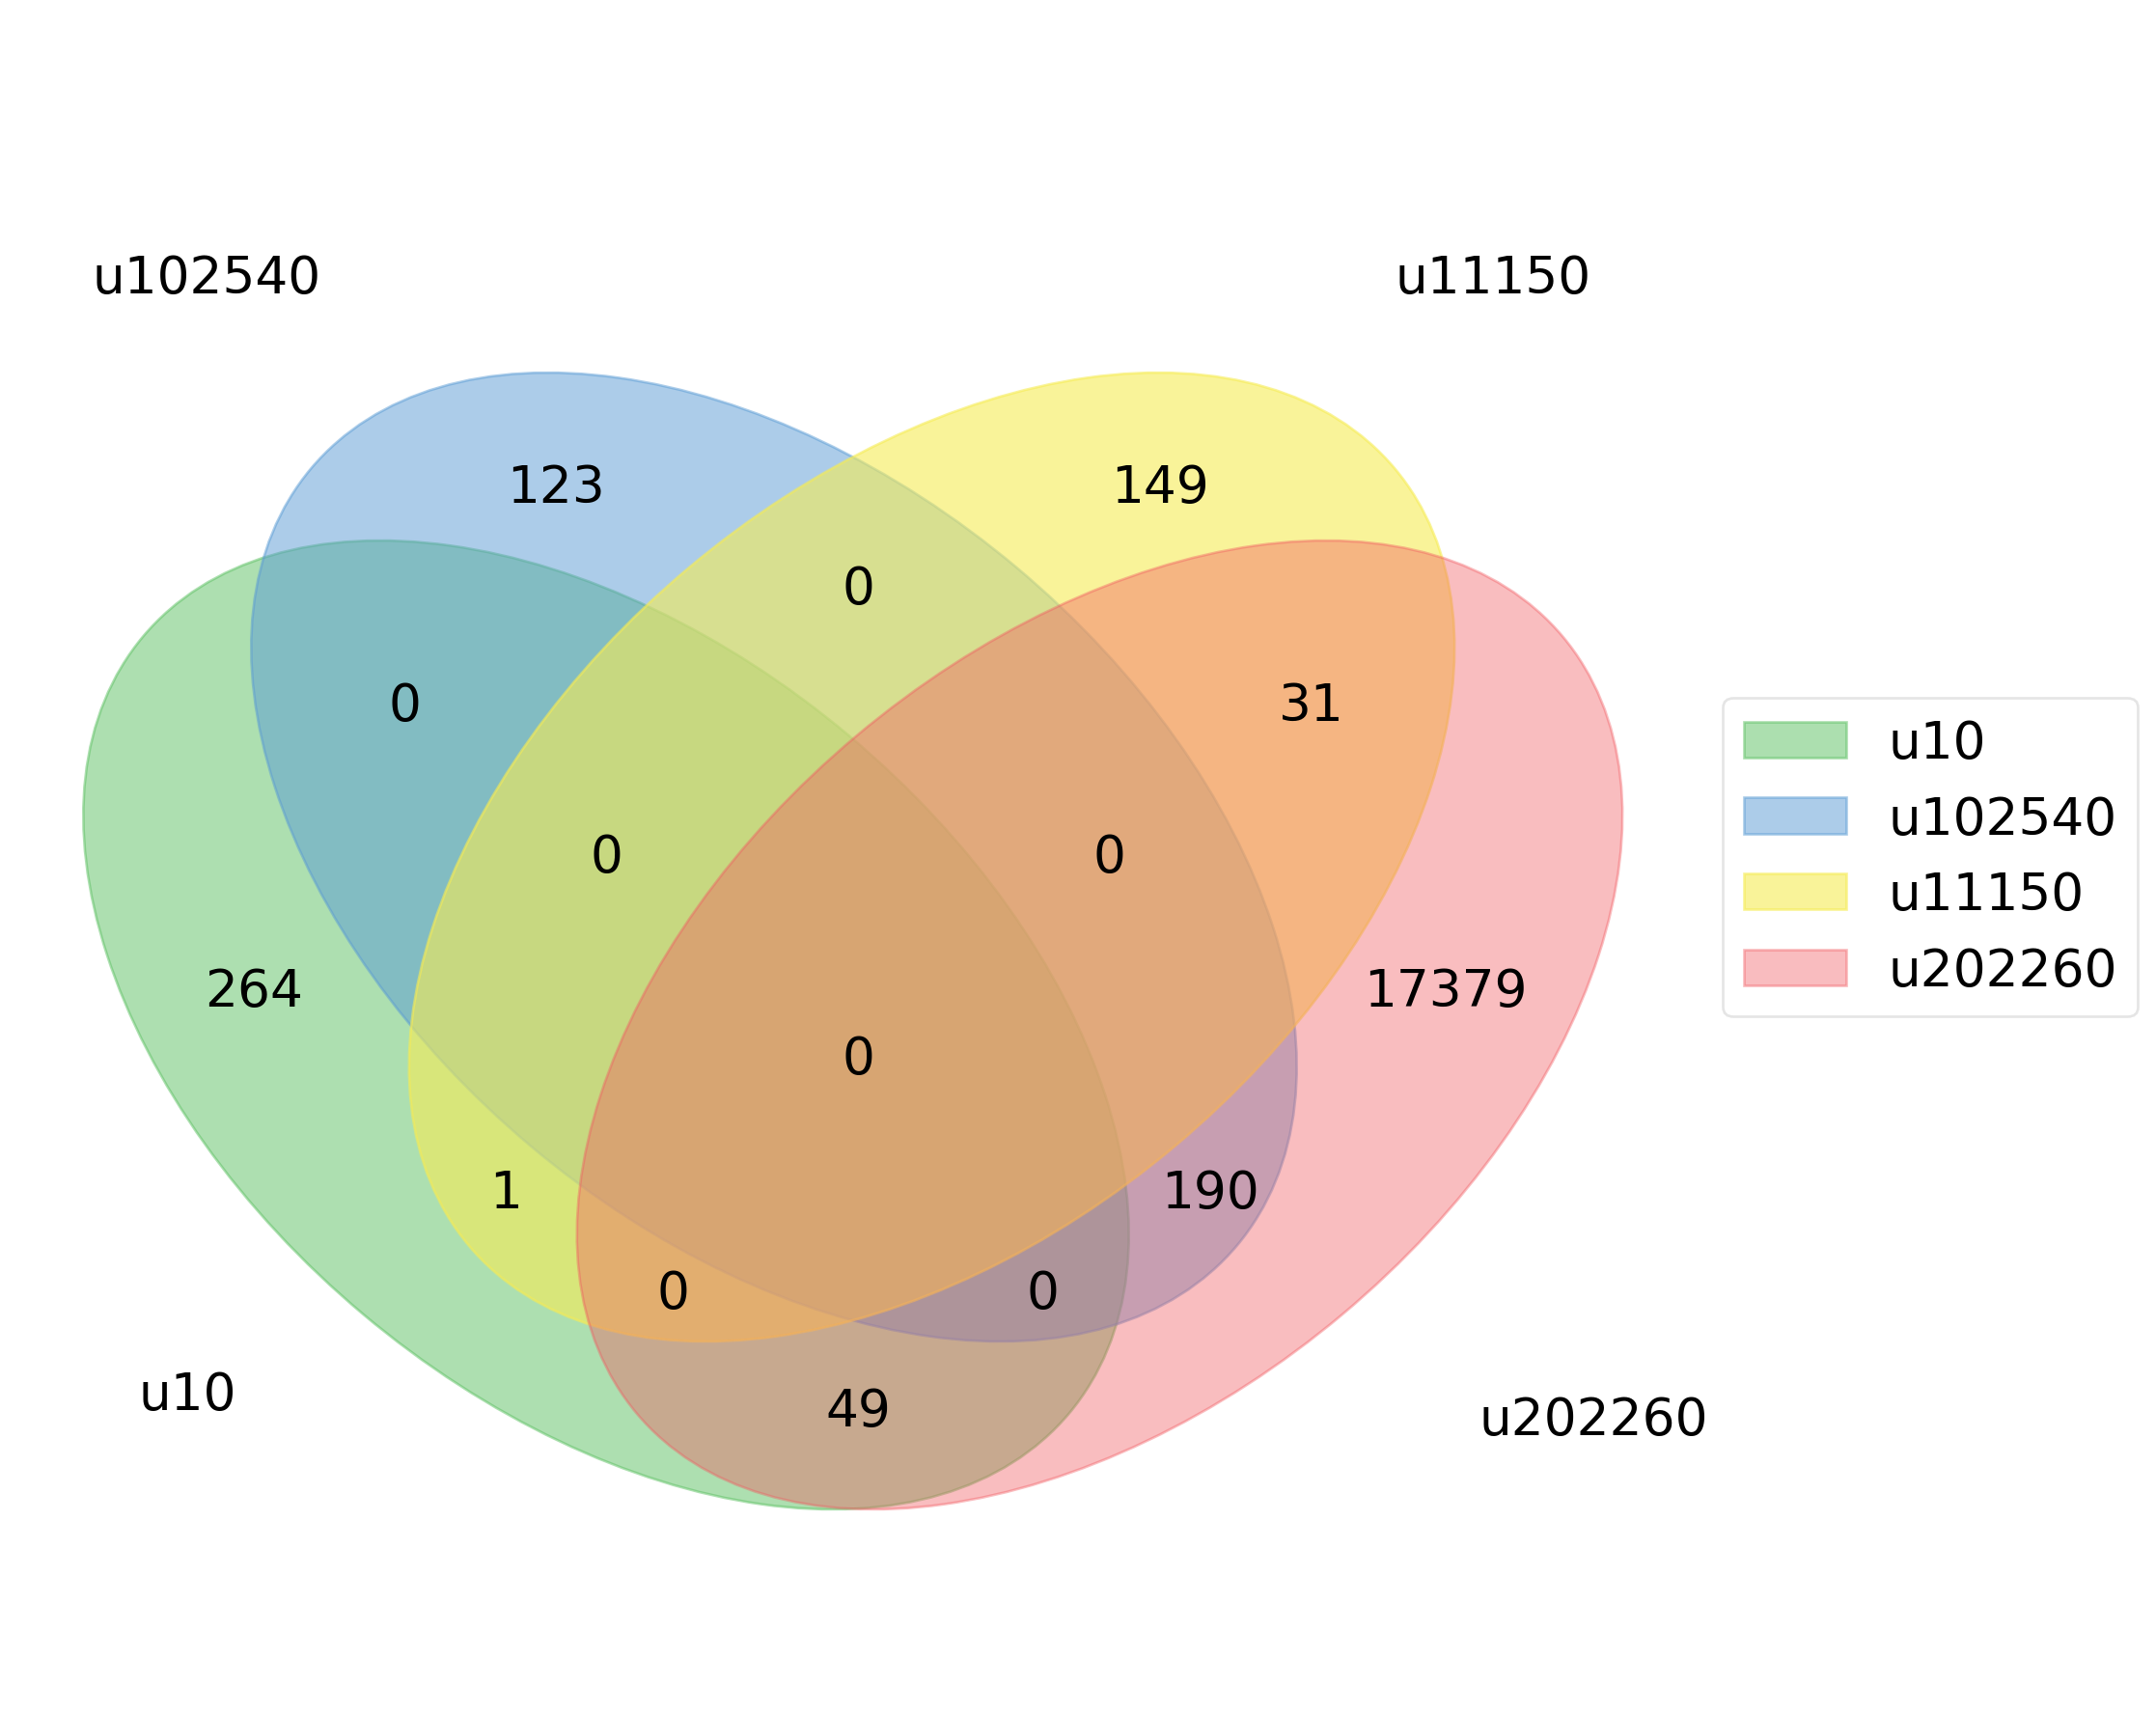

In [13]:
fig, ax = venn.venn4(labels, names=names)
plt.savefig('figures/4.2.1_vir_pos_cell_overlap.png', dpi=300, bbox_inches= 'tight')
fig.show()

In [14]:
palmdb_adata[:, palmdb_adata.var.index == "u202260"].X.sum()

17649.0

# Same for raw count matrix used for models

In [15]:
palmdb_adata_raw = anndata.read(f"{fastq_folder}/full_index_no-host-mask/virus_meta_host.h5ad")
palmdb_adata_raw

AnnData object with n_obs × n_vars = 234946 × 15002
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'
    var: 'v_type'

In [16]:
df_raw = pd.DataFrame()

df_raw["u10"] = nd(palmdb_adata_raw[:, palmdb_adata_raw.var.index == "u10"].X.todense())
df_raw["u102540"] = nd(palmdb_adata_raw[:, palmdb_adata_raw.var.index == "u102540"].X.todense())
df_raw["u11150"] = nd(palmdb_adata_raw[:, palmdb_adata_raw.var.index == "u11150"].X.todense())
df_raw["u202260"] = nd(palmdb_adata_raw[:, palmdb_adata_raw.var.index == "u202260"].X.todense())

In [17]:
labels_raw_temp = get_venn_counts(df_raw)
labels_raw_temp

{'u10_u102540_u11150_u202260': 0,
 'u102540_u11150_u202260': 0,
 'u10_u11150_u202260': 1,
 'u10_u102540_u202260': 0,
 'u10_u102540_u11150': 0,
 'u11150_u202260': 168,
 'u102540_u202260': 319,
 'u102540_u11150': 0,
 'u10_u202260': 310,
 'u10_u11150': 0,
 'u10_u102540': 0,
 'u202260': 217536,
 'u11150': 20,
 'u102540': 4,
 'u10': 3}

In [18]:
labels_raw = rename_labels(labels_raw_temp)
len(labels_raw)

15

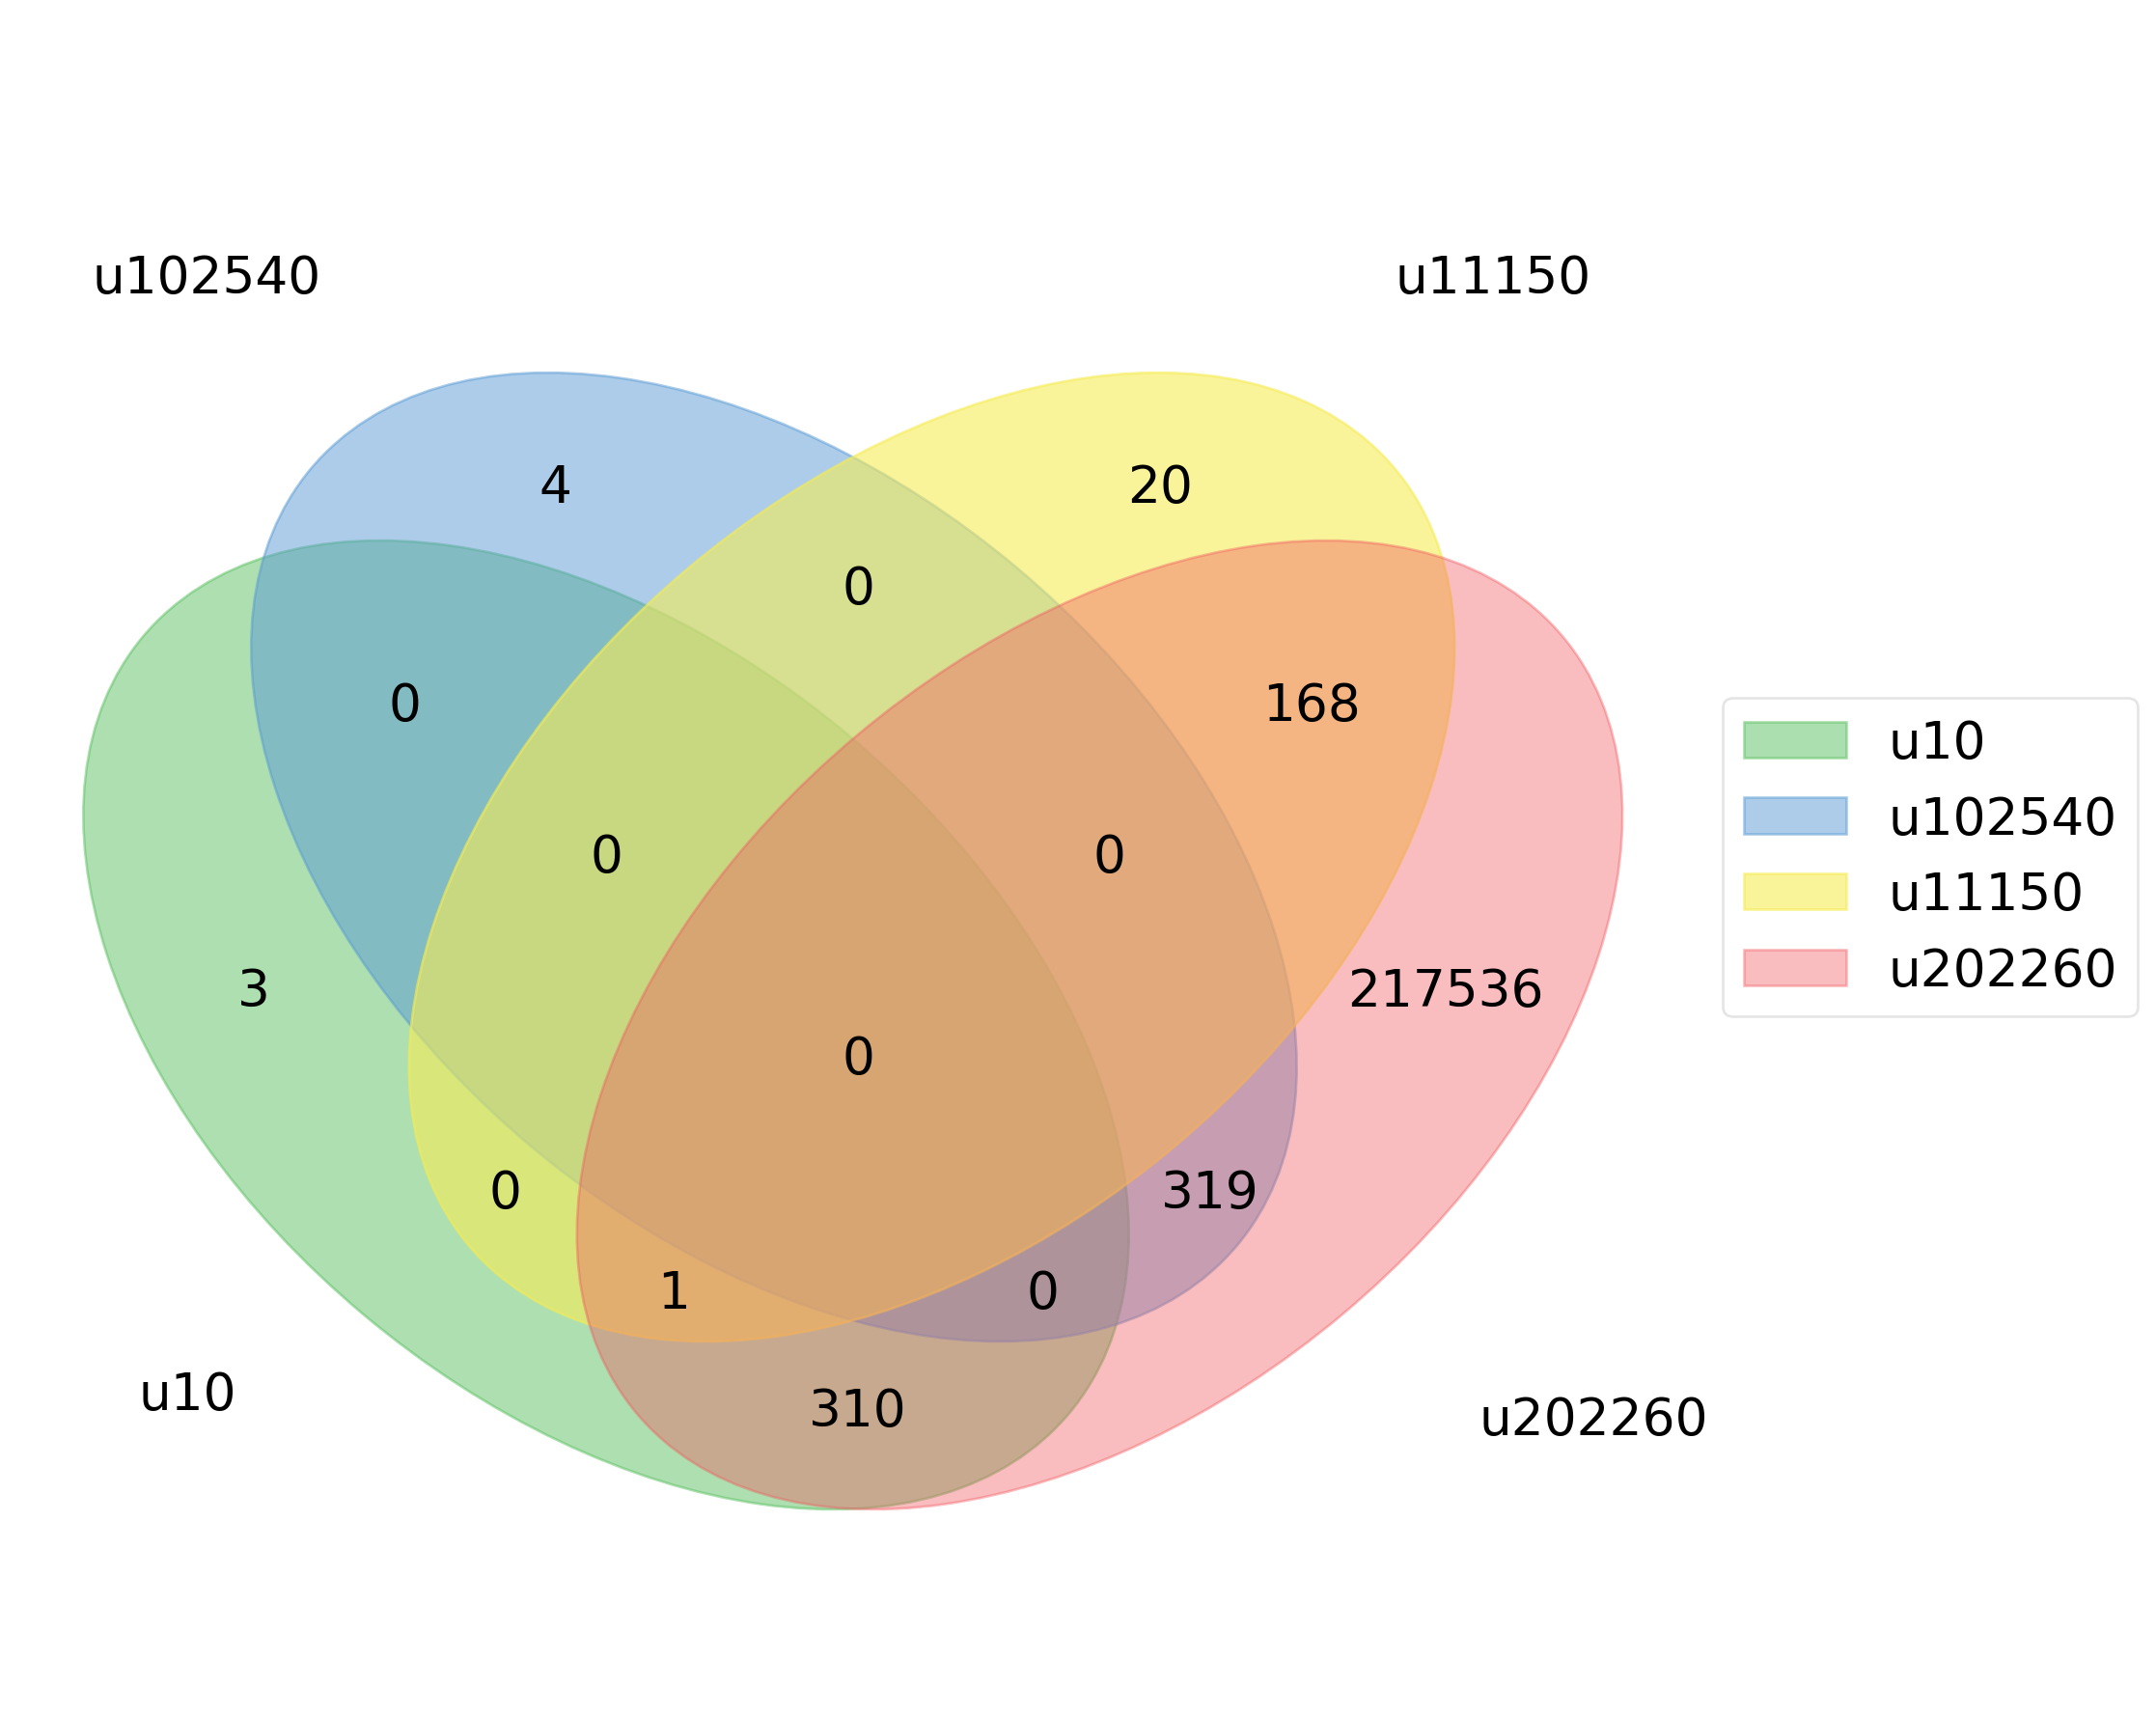

In [19]:
fig, ax = venn.venn4(labels_raw, names=names)
plt.savefig('figures/4.2.1_vir_pos_cell_overlap_unmasked.png', dpi=300, bbox_inches= 'tight')
fig.show()